![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
#matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from math import log
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Lectura de la información de archivo .csv
#data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
data = pd.read_csv('../datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
data["Price"].std()
data["Price"].mean()

14538.403716055265

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

#### Funciones

In [6]:
# Celda 1
#Definición de función para calcular el MAE
def MAE_calculation(y_test, y_pred):
    mae = np.mean(np.abs(y_test - y_pred))
    return mae

#Definición de función para calcular el MSE
def MSE_calculation(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))
    
# Definición de la función best_split_reg para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol en problemas de regresión
def best_split_reg(X, y, num_pct):
    
    # Obtener los percentiles
    percentiles = np.percentile(X, np.arange(0, 100, 100/(num_pct+1))).tolist()
    
    # Agregar los extremos
    percentiles = [-np.inf] + percentiles + [np.inf]
    
    # Inicializar los valores
    best_j, best_split, best_gain = None, None, np.inf
    
    # Recorrer todas las combinaciones de j y split
    for j in range(X.shape[1]):
        for split in percentiles:
            y_l, y_r = y[X.iloc[:, j] < split], y[X.iloc[:, j] >= split]
            if y_l.shape[0] > 0 and y_r.shape[0] > 0:
                y_mean_l, y_mean_r = y_l.mean(), y_r.mean()
                gain = ((y_l - y_mean_l)**2).sum() + ((y_r - y_mean_r)**2).sum()
                if gain < best_gain:
                    best_j, best_split, best_gain = j, split, gain
    
    return best_j, best_split, best_gain


#Definición de función para calibrar la profundidad del árbol
def calibrate_max_depth(num_folds, max_depth_values, X, y):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    result = []
    for max_depth in max_depth_values:
        mse_fold = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            tree = tree_grow(X_train, y_train, max_depth=max_depth)
            y_pred = tree_predict(X_val, tree)
            mse_fold.append(np.mean((y_val - y_pred)**2))
        result.append([max_depth, np.mean(mse_fold)])
    result = np.array(result)
    optimal_max_depth = result[np.argmin(result[:,1]),0]
    return optimal_max_depth


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_std=0, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split_reg(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    y_std = y.std()
    
    tree = dict(y_pred=y_pred, y_std=y_std, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted

#### Ejecución del modelo

In [7]:
num_folds = 10
max_depth_values = range(1,6)
best_max_depth = calibrate_max_depth(num_folds, max_depth_values, X_train, y_train)
tree = tree_grow(X_train, y_train, max_depth=best_max_depth)
y_pred = tree_predict(X_test, tree)
RMSE_tree = MSE_calculation(y_test, y_pred)**0.5
MAE_tree = MAE_calculation(y_test, y_pred)
r2_tree = r2_score(y_test, y_pred)
print('RMSE: ', RMSE_tree)
print('MAE: ', MAE_tree)
print('R2:', r2_tree)

RMSE:  1809.2481571753012
MAE:  1365.6194010371837
R2: 0.785999758393628


En el punto 1, se creó un código para generar árboles de regresión con el fin de predecir los precios de los automóviles. Como medidas de desempeño se utilizó el MAE, en donde se promedian las distancias absolutas entre los valores reales y los valores predichos y el RMSE que se interpreta como una "desviación estandar" con respecto a los valores reales. En el caso del RMSE, dio como resultado 1809 y en el caso del MAE 1365. Teniendo en cuenta que el valor promedio de los automóviles es de 14538 y que la desviación estandar es de 3922, se consideraría que estas medidas son aceptables. Aun así, el modelo es suceptible de mejoras a través de la calibración de los parámetros. EL R2 fue de 0.78, lo que indica que el 78% de las variaciones en el precio pudieron ser explicadas a través de este modelo.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
# Celda 2
# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap
# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_trainb = X_train.iloc[sample, :]
    y_trainb = y_train.iloc[sample]
    treereg.fit(X_trainb, y_trainb)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred=y_pred.mean(axis=1)

RMSE_bag_manual = MSE_calculation(y_test, y_pred)**0.5
MAE_bag_manual = MAE_calculation(y_test, y_pred)
r2_bag_manual = r2_score(y_test, y_pred)

print('RMSE: ', RMSE_bag_manual)
print('MAE: ', MAE_bag_manual)
print('R2: ', r2_bag_manual)

RMSE:  1796.4355868399334
MAE:  1340.0160739030066
R2:  0.7890200013501276


Con un RMSE de 1796.43 y un MAE de 1340.016, podemos decir que el modelo bagging de 10 árboles de regresión tiene un desempeño aceptable para predecir el precio de los automóviles. El MAE indica que el modelo, en promedio, se desvía en 1340.016 unidades del precio real, mientras que el RMSE indica que la dispersión de los errores de predicción es de 1796.43 unidades en promedio.

Además, si se compara con el modelo de árboles manual, logra un mejor rendimiento pues tanto RMSE como MAE son menores para el modelo de bagging. El R2 también mejoró levemente.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [9]:
# Celda 3

max_features = int(log(X_train.shape[1]))
tree_reg = DecisionTreeRegressor()
bag_reg = BaggingRegressor(base_estimator=tree_reg, n_estimators=10, max_features=max_features)
bag_reg.fit(X_train, y_train)
y_pred = bag_reg.predict(X_test)

RMSE_bag = MSE_calculation(y_test, y_pred)**0.5
MAE_bag = MAE_calculation(y_test, y_pred)
r2_bag = r2_score(y_test, y_pred)

print('RMSE: ', RMSE_bag)
print('MAE: ', MAE_bag)
print('R2: ', r2_bag)

RMSE:  2526.318122407954
MAE:  1949.164880551567
R2:  0.5827521949559253


Comparando los resultados del segundo modelo de Bagging con los del primer modelo de Bagging (manual), podemos observar que el RMSE y el MAE del segundo modelo son mayores que los del primer modelo. Esto puede indicar que el segundo modelo tiene un desempeño inferior para predecir el precio de los automóviles.

El hecho de que el segundo modelo haya utilizado el logaritmo del número total de features como valor para el parámetro max_features puede indicar que se intentó reducir la complejidad del modelo al limitar el número de features considerados en cada árbol de regresión. Sin embargo, es importante señalar que la selección del valor adecuado para este parámetro puede ser un proceso complejo y debe basarse en la exploración de diferentes opciones y técnicas de validación. Por lo tanto, la reducción de complejidad no es suficiente por sí sola para obtener un mejor resultado, siendo necesario aun explorar algún método de calibración.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [10]:
# Celda 4
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

RMSE_rf = MSE_calculation(y_test, y_pred)**0.5
MAE_rf = MAE_calculation(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print('RMSE: ', RMSE_rf)
print('MAE: ', MAE_rf)
print('R2: ', r2_rf)

RMSE:  1758.1086780656174
MAE:  1309.794721197602
R2:  0.7979264733245044


En este punto se utilizó un modelo de Random forest aún sin calibración de parámetros. Este modelo da como resultado un mejor desempeño que los observados en los dos puntos anteriores, teniendo menores valores tanto en RMSE como en el MAE y con un R2 de 0.7979 lo que indica que se alcanzan a explicar el 79.79% de las variaciones en el precio con este modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

,RMSE,n_estimators,max_features,max_depth
0,2838.360335,10,1,1
1,2473.382866,10,1,2
2,2185.392011,10,1,3
3,1903.167244,10,1,4
4,1798.435901,10,1,5
...,...,...,...,...
5395,1688.681795,300,9,16
5396,1702.464236,300,9,17
5397,1714.061550,300,9,18
5398,1724.240945,300,9,19


RMSE mínimo: 1550.0807439441892
MAE:  1284.334486289437
R2:  0.8039081821335348
Número óptimo de estimadores: 80
Número óptimo de variables: 4
Número óptimo de profundidad: 8


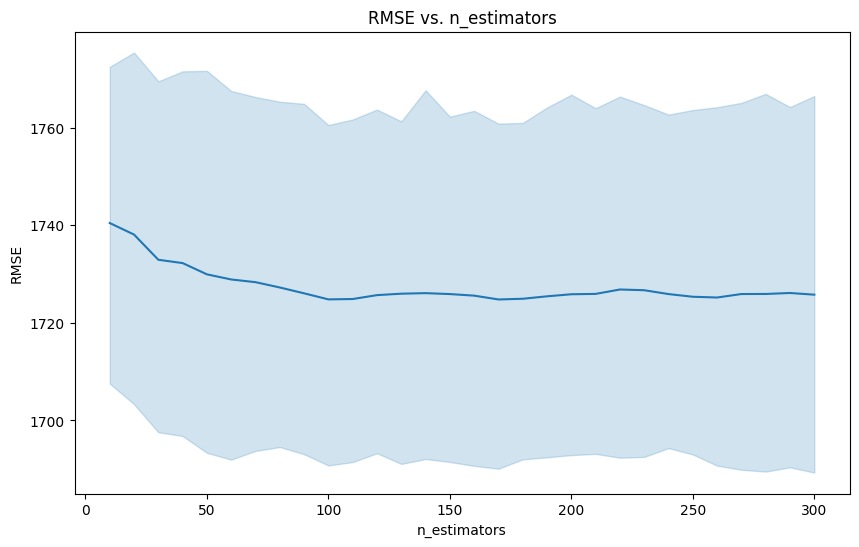

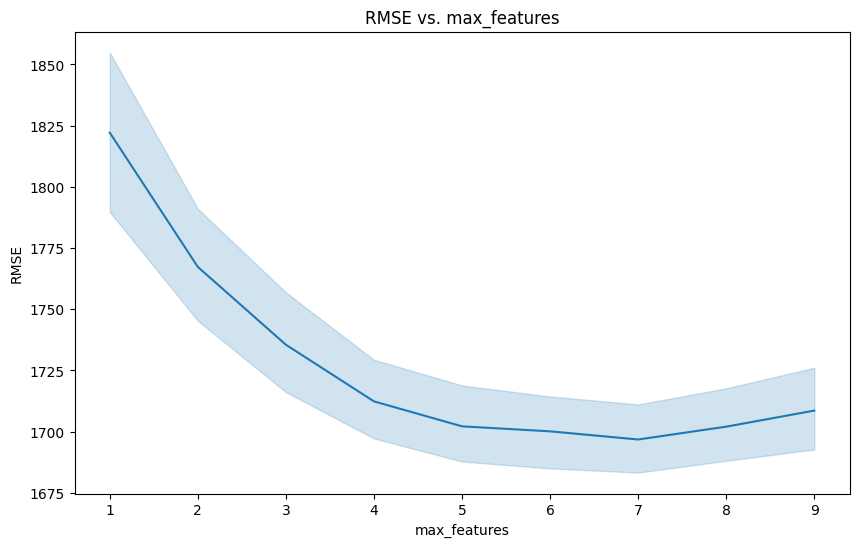

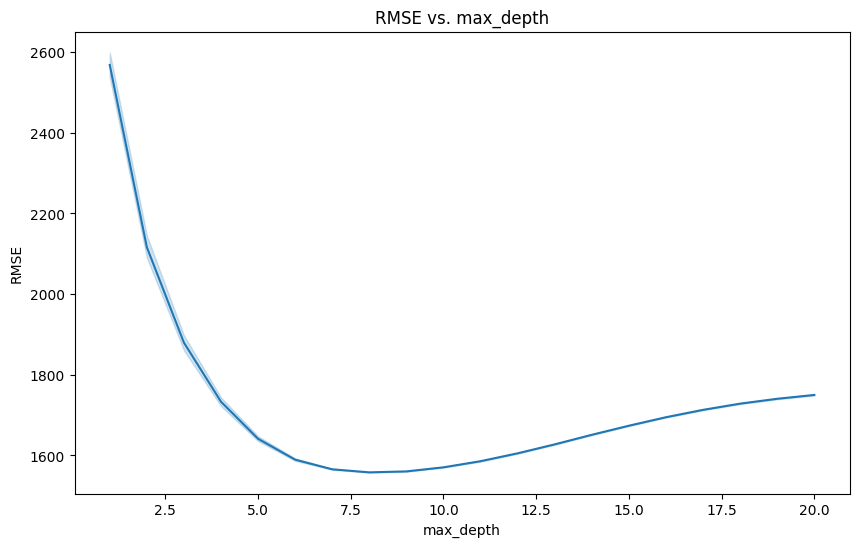

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Parámetros para calibrar
parameters = ['n_estimators', 'max_features', 'max_depth']

# Lista de valores para cada parámetro
n_estimators = range(10, 310, 10)
max_features = range(1, X_train.shape[1]+1)
max_depth = range(1,21)
values = [n_estimators, max_features, max_depth]

# Diccionario para parámetros y sus valores
param_grid = dict(zip(parameters, values))

# Lista para guardar los valores de RMSE para cada combinación de parámetros
rmse_scores = []

# Calibración de parámetros
for n_estimators in param_grid['n_estimators']:
    for max_features in param_grid['max_features']:
        for max_depth in param_grid['max_depth']:
            rf_reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=1, n_jobs=-1)
            rf_reg.fit(X_train, y_train)
            y_pred = rf_reg.predict(X_test)
            rmse_scores.append(np.sqrt(mean_squared_error(y_pred, y_test)))

# Creación de un DataFrame con los valores de RMSE para cada combinación de parámetros
rmse_df = pd.DataFrame(rmse_scores, columns=['RMSE'])
rmse_df['n_estimators'] = np.repeat(param_grid['n_estimators'], len(param_grid['max_features'])*len(param_grid['max_depth']))
rmse_df['max_features'] = np.tile(np.repeat(param_grid['max_features'], len(param_grid['max_depth'])), len(param_grid['n_estimators']))
rmse_df['max_depth'] = np.tile(param_grid['max_depth'], len(param_grid['n_estimators'])*len(param_grid['max_features']))
display(rmse_df)

best_rmse = min(rmse_df['RMSE'])
min_index = rmse_df['RMSE'].idxmin()
best_n_estimators = rmse_df.loc[min_index, 'n_estimators']
best_max_features = rmse_df.loc[min_index, 'max_features']
best_max_depth = rmse_df.loc[min_index, 'max_depth']

rf_reg = RandomForestRegressor(n_estimators=best_n_estimators, max_features=best_max_features, max_depth=best_max_depth, random_state=1, n_jobs=-1)
RMSE_rf = MSE_calculation(y_test, y_pred)**0.5
MAE_rf = MAE_calculation(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print(f'RMSE mínimo: {best_rmse}')
print('MAE: ', MAE_rf)
print('R2: ', r2_rf)
print(f'Número óptimo de estimadores: {best_n_estimators}')
print(f'Número óptimo de variables: {best_max_features}')
print(f'Número óptimo de profundidad: {best_max_depth}')

# Gráfico de RMSE vs. n_estimators
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='n_estimators', y='RMSE', data=rmse_df, ax=ax)
ax.set_title('RMSE vs. n_estimators')
ax.set_xlabel('n_estimators')
ax.set_ylabel('RMSE')
plt.show()

# Gráfico de RMSE vs. max_features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='max_features', y='RMSE', data=rmse_df, ax=ax)
ax.set_title('RMSE vs. max_features')
ax.set_xlabel('max_features')
ax.set_ylabel('RMSE')
plt.show()

# Gráfico de RMSE vs. max_depth
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='max_depth', y='RMSE', data=rmse_df, ax=ax)
ax.set_title('RMSE vs. max_depth')
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSE')
plt.show()

El menor RMSE se alcanza con: 120 n_estimators y es igual a 1755.3655840329534
El menor RMSE se alcanza con: 9 max_features y es igual a 1755.3655840329534
El menor RMSE se alcanza con: 8 max_depth y es igual a 1564.347576097859
El menor RMSE se alcanza con: 120 n_estimators, 9 max_features y 8 max_depth y es igual a 1564.347576097859


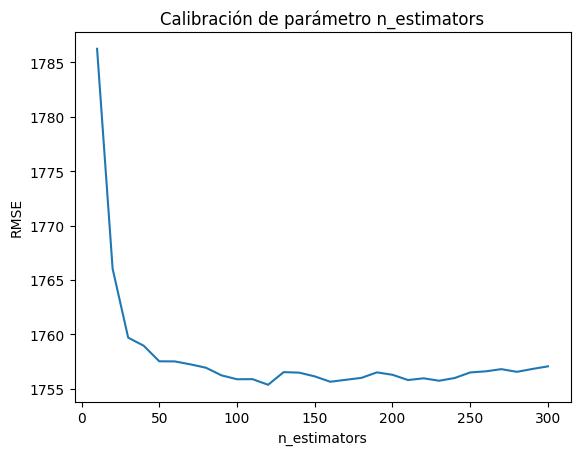

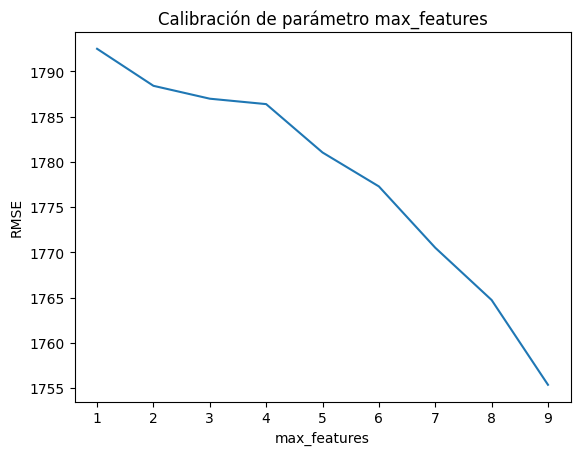

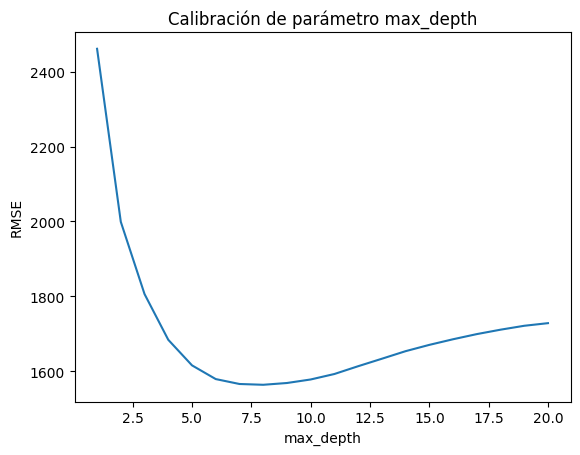

In [12]:
# Celda 5
import matplotlib.pyplot as plt

# Función para encontrar el mínimo de una lista
def find_min(scores, range, parameter):
    min_index = np.argmin(scores)
    print(f'El menor RMSE se alcanza con: {range[min_index]} {parameter} y es igual a {min(scores)}')
    return min_index, scores[min_index]

# Parámetros para calibrar
# Lista de valores para cada parámetro
n_estimators = range(10, 310, 10)
max_features = range(1, X_train.shape[1]+1)
max_depth = range(1,21)

# Lista para guardar los valores de RMSE para cada combinación de parámetros
rmse_scores_estimators = []
rmse_scores_features = []
rmse_scores_depth = []

# Calibración de los estimadores
for estimators in n_estimators:
    rf_reg = RandomForestRegressor(n_estimators=estimators, random_state=1, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    rmse_scores_estimators.append(np.sqrt(mean_squared_error(y_pred, y_test)))

min_index, rmse_est_calib = find_min(rmse_scores_estimators, n_estimators, 'n_estimators')
max_estimators = n_estimators[min_index]

# Calibración de los features
for feature in max_features:
    rf_reg = RandomForestRegressor(n_estimators=max_estimators, max_features=feature, random_state=1, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    rmse_scores_features.append(np.sqrt(mean_squared_error(y_pred, y_test)))

min_index, rmse_feat_calib = find_min(rmse_scores_features, max_features, 'max_features')
max_features_calib = max_features[min_index]

# Calibración de la profundidad
for depth in max_depth:
    rf_reg = RandomForestRegressor(n_estimators=max_estimators, max_features=max_features_calib, max_depth=depth, random_state=1, n_jobs=-1)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    rmse_scores_depth.append(np.sqrt(mean_squared_error(y_pred, y_test)))

min_index, rmse_depth_calib = find_min(rmse_scores_depth, max_depth, 'max_depth')
max_depth_calib = max_depth[min_index]

print(f'El menor RMSE se alcanza con: {max_estimators} n_estimators, {max_features_calib} max_features y {max_depth_calib} max_depth y es igual a {rmse_depth_calib}')

# Gráficas
plt.plot(n_estimators, rmse_scores_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('Calibración de parámetro n_estimators')
plt.show()

plt.plot(max_features, rmse_scores_features)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title('Calibración de parámetro max_features')
plt.show()

plt.plot(max_depth, rmse_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Calibración de parámetro max_depth')
plt.show()

En este punto se utilizaron dos estrategias diferentes para la optimización de los parámetros solicitados. En la primera estrategia, la optimización se realizó de manera simultánea para los tres parámetros, dando como resultado 80 estimadores, 4 parámetros y una máxima profundidad de 8. El RMSE fue de 1550 y el MAE de 1284.

La segunda estrategia consistió en realizar la optimización de forma secuencial a través de Grid Search, dando como resultado 120 estimadores, 9 variables y una máxima profundidad de 8. El RMSE es igual a 1564.3, empeorando el resultado de la primera estrategia y, además usando una mayor cantidad de variables.

En cuanto a la primera estrategia, se mejora el resultado con respecto a los demás modelos.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [13]:
# Celda 6
# Importación y definición de modelo XGBRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

clf = XGBRegressor()

# Entrenamiento (fit) y desempeño del modelo XGBRegressor
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluar el desempeño del modelo utilizando el error cuadrático medio (MSE) y el coeficiente de determinación (R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
RMSE_xgb = MSE_calculation(y_test, y_pred)**0.5
MAE_xgb = MAE_calculation(y_test, y_pred)

print("MSE: ", mse)
print("R2 score: ", r2)
print("RMSE: ", RMSE_xgb)
print("MAE: ", MAE_xgb)

MSE:  2629001.844928506
R2 score:  0.8281265175296673
RMSE:  1621.4197004256812
MAE:  1186.634392366123


El modeo realizado con XGBoost mejora los resultados tanto del R2 como del MAE con respecto a los casos anteriores, pero, si bien obtiene un buen RMSE, no es el más bajo. Aun así, estos mejores resultados se logran antes de realizar la calibración de los parámetros.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [14]:
# Celda 7
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Definir los valores posibles para cada parámetro
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0.1, 0.01, 0.001],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

# Crear una instancia del modelo XGBRegressor
clf = XGBRegressor()

# Realizar la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores valores de los parámetros
best_params = grid_search.best_params_

# Entrenar el modelo con los mejores valores de los parámetros
clf = XGBRegressor(**best_params)
clf.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred = clf.predict(X_test)

# Evaluar el desempeño del modelo utilizando el error cuadrático medio (MSE) y el coeficiente de determinación (R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
RMSE_xgb_grid = MSE_calculation(y_test, y_pred)**0.5
MAE_xgb_grid = MAE_calculation(y_test, y_pred)

print("MSE: ", mse)
print("R2 score: ", r2)
print("RMSE: ", RMSE_xgb_grid)
print("MAE: ", MAE_xgb_grid)

MSE:  2383682.554729021
R2 score:  0.8441644981819335
RMSE:  1543.9179235726947
MAE:  1132.6514738933045


learning rate: Este parámetro controla la tasa de aprendizaje del modelo y se utiliza para reducir la contribución de cada árbol en el modelo. Un valor más bajo de learning rate puede hacer que el modelo tenga una mejor generalización, pero a costa de una mayor cantidad de árboles necesarios para obtener una precisión similar. Un valor demasiado alto puede hacer que el modelo tenga un sobreajuste y una precisión insuficiente. Es recomendable probar varios valores para encontrar el óptimo.

gamma: Este parámetro controla la reducción de la función de pérdida requerida para hacer una partición adicional en un nodo de un árbol. Un valor más alto de gamma hace que el modelo sea más conservador y se detenga antes de hacer particiones innecesarias, lo que puede ayudar a prevenir el sobreajuste. Sin embargo, un valor demasiado alto también puede hacer que el modelo no capture suficientes detalles importantes en los datos, lo que puede disminuir la precisión.

colsample_bytree: Este parámetro controla la proporción de características utilizadas por cada árbol. Un valor más bajo de colsample_bytree puede reducir el sobreajuste y hacer que el modelo tenga una mejor generalización, pero a costa de una menor capacidad para capturar detalles importantes en los datos. Un valor demasiado alto puede hacer que el modelo tenga un sobreajuste y una precisión insuficiente.

Con la calibración de estos resultados se logra un desempeño que en comparación es superior a todos los obtenidos en los casos previos, obteniendo menores RMSE y MAE y un mayor R2

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

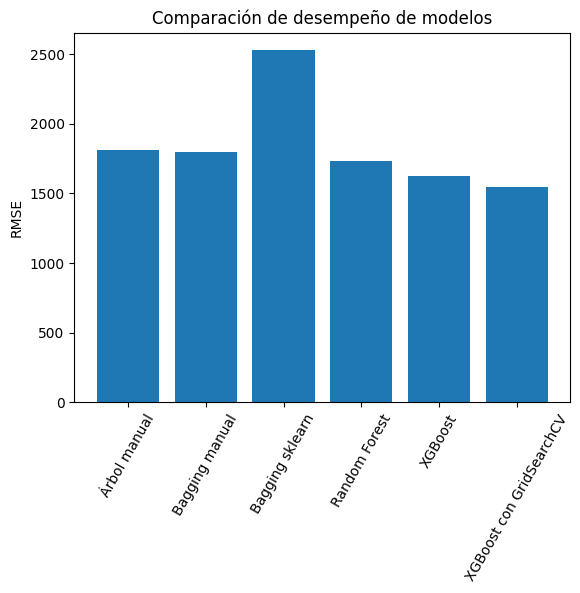

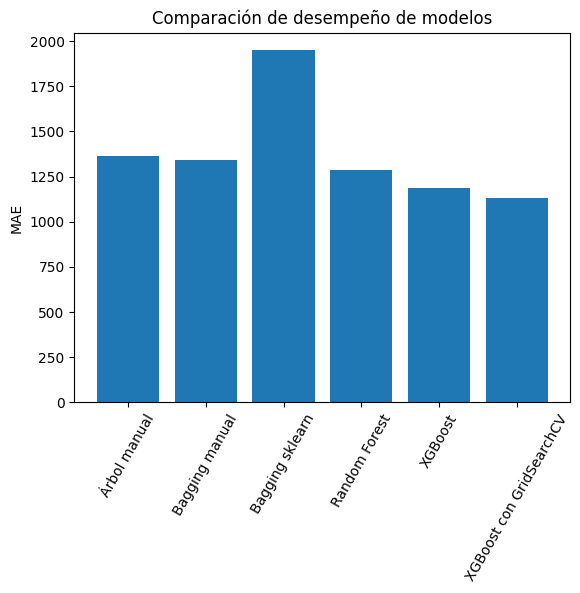

,Modelo,RMSE,MAE
0,Árbol manual,1809.248157,1365.619401
1,Bagging manual,1796.435587,1340.016074
2,Bagging sklearn,2526.318122,1949.164881
3,Random Forest,1731.891750,1284.334486
4,XGBoost,1621.419700,1186.634392
5,XGBoost con GridSearchCV,1543.917924,1132.651474


In [15]:
# Celda 8

# Gráfica de comparación de desempeño
plt.bar(['Árbol manual', 'Bagging manual', 'Bagging sklearn', 'Random Forest', 'XGBoost', 'XGBoost con GridSearchCV'], [RMSE_tree, RMSE_bag_manual, RMSE_bag, RMSE_rf, RMSE_xgb, RMSE_xgb_grid])
plt.ylabel('RMSE')
plt.title('Comparación de desempeño de modelos')
plt.xticks(rotation = 60) 
plt.show()

plt.bar(['Árbol manual', 'Bagging manual', 'Bagging sklearn', 'Random Forest', 'XGBoost', 'XGBoost con GridSearchCV'], [MAE_tree, MAE_bag_manual, MAE_bag, MAE_rf, MAE_xgb, MAE_xgb_grid])
plt.ylabel('MAE')
plt.title('Comparación de desempeño de modelos')
plt.xticks(rotation = 60) 
plt.show()

# Dataframe de comparación de desempeño
df = pd.DataFrame({'Modelo': ['Árbol manual', 'Bagging manual', 'Bagging sklearn', 'Random Forest', 'XGBoost', 'XGBoost con GridSearchCV'], 'RMSE': [RMSE_tree, RMSE_bag_manual, RMSE_bag, RMSE_rf, RMSE_xgb, RMSE_xgb_grid], 'MAE': [MAE_tree, MAE_bag_manual, MAE_bag, MAE_rf, MAE_xgb, MAE_xgb_grid]})
df



El modelo XGBoost con calibración a través de Gridsearch es el que obtiene los menores valores del RMSE y del MAE. Además otorga un mayor R2, lo que indica que hay un mejor poder predictivo. En este modelo el RMSE fue de 1543, lo que indica una desviación de este valor con respecto a los valores reales. El MAE tuvo un valor de 1132 lo que indica que las predicciones tienden a alejarse del valor real en 1132 en promedio.